In [1]:
# Use Python 3.12

%pip install GAICo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

clean_df = pd.read_csv("../../qa_answered_clean.csv")
dirty_df = pd.read_csv("../../qa_answered_dirty.csv")
base_df =  pd.read_csv("../../qa_answered_base.csv")

# Rename the "generated_answer" column in each df
clean_df = clean_df.rename(columns={"generated_answer": "clean"})
dirty_df = dirty_df.rename(columns={"generated_answer": "dirty"})
base_df  = base_df.rename(columns={"generated_answer": "base"})

# Merge them together on (question, answer)
df = (
    clean_df.merge(dirty_df, on=["question", "answer"], how="outer")
            .merge(base_df, on=["question", "answer"], how="outer")
)

df


,question,answer,clean,dirty,base
0,How did Mr. McCray travel to the Trinity Babti...,Automobile,I don't have information about Mr. McCray or h...,"Unfortunately, I couldn't find any information...",I don't have information on Mr. McCray traveli...
1,What column did Mr. McKaine write?,The Journal and Guide,I don't have information on a person named Mr....,I don't have any information on a person named...,I'm not aware of any information about a perso...
2,What committee did John H. McCray get invited ...,National Citizens Political Action Committee,I am unable to locate any information on a per...,I don't have information on a person named Joh...,I don't have information on John H. McCray bei...
3,What did Jack Greenburg thank Mr. John McCray ...,thank you letter,I'm sorry but I could not verify what Jack Gre...,I do not have any information about Jack Green...,I couldn't find any information on Jack Greenb...
4,What year did the Progressive Democratic Party...,1948,The Progressive Democratic Party was a faction...,There is no record of a political party called...,"I'm not aware of any information about a ""Prog..."
5,Where did John H. McCray meet with Mr. Chism o...,Florence,I don't have any information on a meeting betw...,I don't have specific information on where Joh...,I couldn't find any information on a person na...
6,Who was the president at this time?,Truman,"This conversation just started, so I don't hav...","However, I don't have enough information to de...","As my knowledge cutoff is 2023-12, I can tell ..."
7,Who was the state treasurer?,J. C. Artanus,There have been many state treasurers througho...,"Unfortunately, there are multiple state treasu...",I don't have enough information to provide a s...


In [6]:
# Combine into one dataframe

llm_names = df.columns[2:]

print(llm_names)


Index(['clean', 'dirty', 'base'], dtype='object')


In [4]:
from gaico.metrics import (
    BLEU,
    ROUGE,
    JSDivergence,
    JaccardSimilarity,
    LevenshteinDistance,
    BERTScore,
)

# Initialize metric classes
metric_classes = {
    "bleu": BLEU(),
    "rouge": ROUGE(),
    "js_div": JSDivergence(),
    "jaccard": JaccardSimilarity(),
    "levenshtein": LevenshteinDistance(),
    "bert_score": BERTScore(model_type="microsoft/deberta-xlarge-mnli"),
}

/home/alex/miniconda3/envs/library_eval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def calculate_metrics(ground_truth, prediction):
    return {
        "BLEU": metric_classes["bleu"].calculate(ground_truth, prediction),
        "ROUGE-L": metric_classes["rouge"].calculate(ground_truth, prediction).get("rougeL", 0),
        "JSD": metric_classes["js_div"].calculate(ground_truth, prediction),
        "Jaccard": metric_classes["jaccard"].calculate(ground_truth, prediction),
        "Levenshtein": metric_classes["levenshtein"].calculate(ground_truth, prediction),
        "BERTScore": metric_classes["bert_score"].calculate(ground_truth, prediction).get("f1", 0),
    }

In [7]:
def process_row(row):
    ground_truth = row["answer"]
    return {model: calculate_metrics(ground_truth, row[model]) for model in llm_names}

In [10]:
# Convert DataFrame to list of dictionaries
data = df.to_dict("records")

In [13]:
import concurrent
from tqdm import tqdm
# Use concurrent.futures for parallelization
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit all tasks
    future_to_row = {executor.submit(process_row, row): row for row in data}

    # Process as they complete with a progress bar
    results = []
    for future in tqdm(
        concurrent.futures.as_completed(future_to_row),
        total=len(data),
        desc="Processing",
    ):
        results.append(future.result())

Processing: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


In [14]:
# Restructure the results
results = {model: [row[model] for row in results] for model in llm_names}

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import os
from pathlib import Path

def create_radar_plot(results):
    """
    Creates a radar plot to compare all models across different metrics.

    :param results: A dictionary containing metric scores for each model.
    """
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    # Number of variables (metrics)
    num_metrics = len(metrics)

    # Compute the angle for each metric axis
    angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
    angles += angles[:1]  # Complete the loop for a full circle

    # Plot each model's scores
    for model in llm_models:
        metric_scores = [
            np.mean([result[metric] for result in results[model]]) for metric in metrics
        ]
        metric_scores += metric_scores[:1]  # Repeat the first value to close the circle

        # Plot the data for each model
        ax.plot(angles, metric_scores, linewidth=2, linestyle="solid", label=model)
        ax.fill(angles, metric_scores, alpha=0.25)

    # Add the metric labels on the plot
    plt.xticks(angles[:-1], metrics, color="grey", size=12)

    # Set the y-label for the metrics (assuming scores are comparable)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.yaxis.grid(True, color="#DAD8D7")

    # Add a title
    plt.title("LLM Performance Across Multiple Metrics", size=14, weight="bold", pad=20)

    # Add legend
    plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1), fontsize=12, frameon=False)

    # Set a white background for the figure
    fig.patch.set_facecolor("white")

    # Save the plot
    save_dir = os.path.join("..", "data", "llm_faq", "plots", "radar_charts")
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{save_dir}/overall_radar_chart.png", bbox_inches="tight")

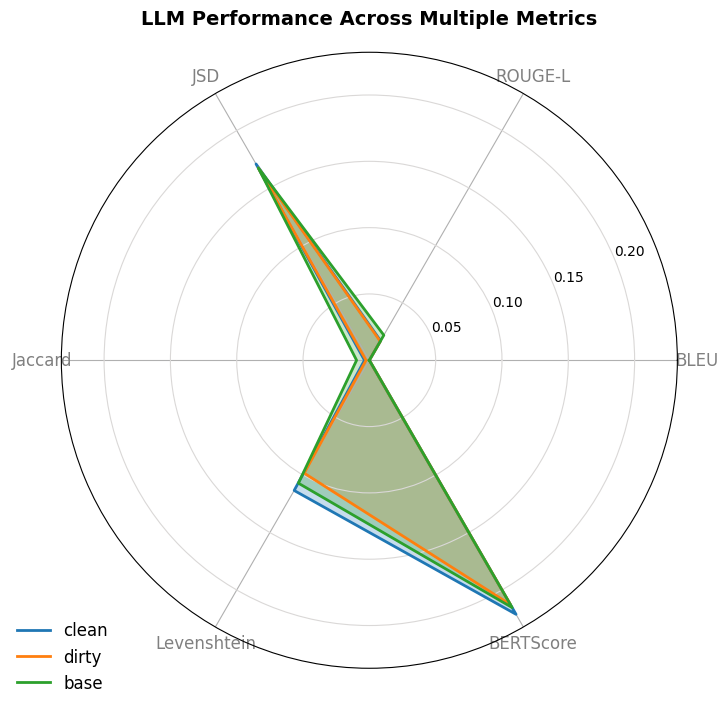

In [21]:
create_radar_plot(results)